# Nutria
In this Notebook we'll consider the population growth of the Nutria species. The data has been taken from .. . We'll begin importing the data and visualizing it.

<AxesSubplot:title={'center':'Nutria population'}>

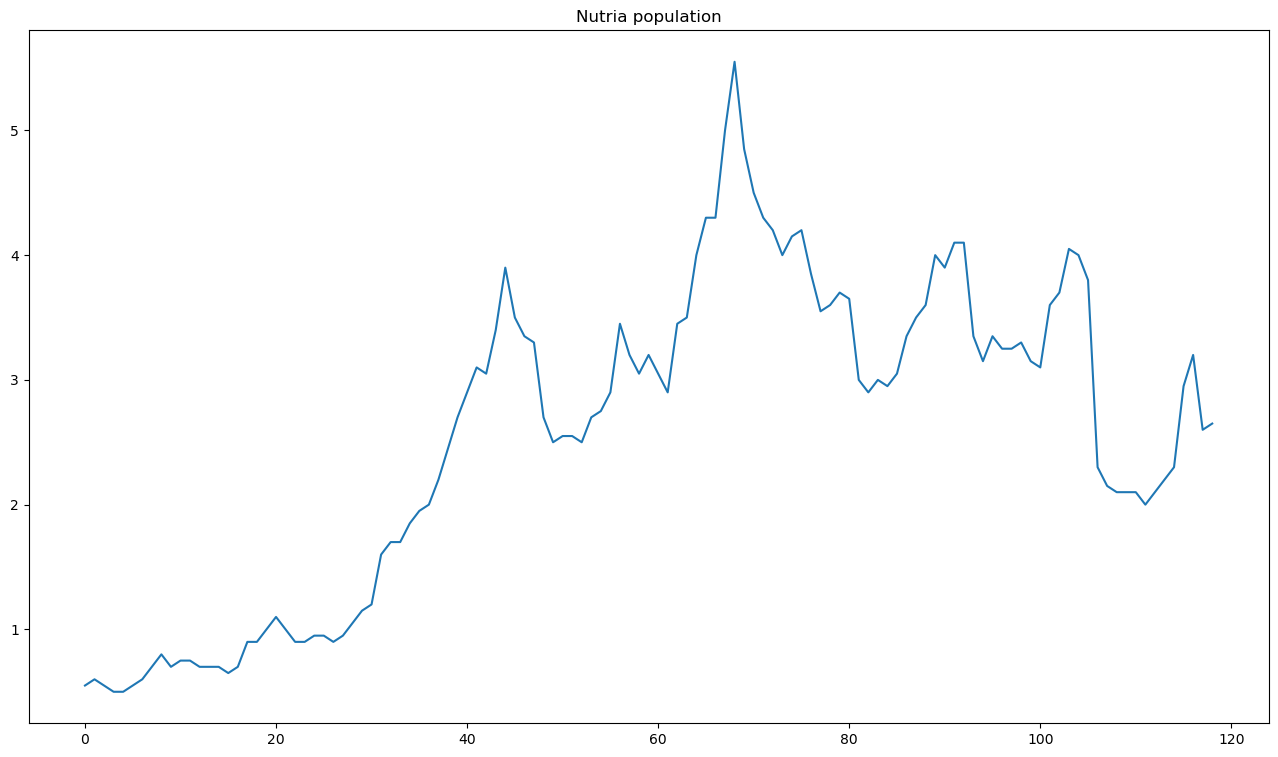

In [1]:
import pandas as pd

data = pd.read_csv("nutria.txt", sep="\t").iloc[:, 0].rename("nutria")

data.plot(figsize=(16, 9), title="Nutria population")

We'll use the same model as in [stoch-proc](https://github.com/tingiskhan/stoch-proc/blob/master/examples/nutria.ipynb), and thus get

In [2]:
from pyfilter import inference as inf, filters as filts, __version__
from stochproc import timeseries as ts, __version__ as sp_version, distributions as dists
from pyro.distributions import LogNormal, Exponential, Gamma, InverseGamma, Normal
from torch.distributions import Distribution
from math import log


def f(x, a, b, c, sigma_e):
    exped = x.value.exp()
    return x.value + a + b * exped + c * exped ** 2, sigma_e


print(f"stoch-proc: {sp_version}")
print(f"pyfilter: {__version__}")


def initial_kernel(a, b, c, sigma_e):
    return Normal(torch.zeros_like(a), torch.ones_like(a))


def build_model(context: inf.InferenceContext):
    a = context.named_parameter("a", Normal(loc=0.0, scale=1.0).cuda())
    b = context.named_parameter("b", Normal(loc=0.0, scale=1.0).cuda())
    c = context.named_parameter("c", Normal(loc=0.0, scale=1.0).cuda())
    
    alpha = data.shape[0] / 2.0
    beta = 2 * (alpha - 1.0) / 10.0     
    sigma_e = context.named_parameter("sigma_e", InverseGamma(concentration=alpha, rate=beta).cuda()).sqrt()

    inc_dist = Normal(torch.zeros_like(a), torch.ones_like(a))
    hidden = ts.AffineProcess(f, (a, b, c, sigma_e), inc_dist, initial_kernel=initial_kernel)
        
    sigma_n = context.named_parameter("sigma_n", InverseGamma(concentration=alpha, rate=beta).cuda()).sqrt()
    a = torch.ones_like(sigma_n)
    b = torch.zeros_like(sigma_n)
    
    return ts.LinearStateSpaceModel(hidden, (a, b, sigma_n), torch.Size([]))


stoch-proc: 0.3.0
pyfilter: 0.28.0


Next, we'll use SMC2 together with APF to perform inference on the logged dataset.

In [3]:
from pyfilter.inference.sequential import SMC2
from pyfilter.filters.particle import APF, proposals as p
import torch


logged_data = torch.from_numpy(data.values).float().log().cuda()


results = list()
for i in range(2):
    with inf.make_context() as context:
        filt = APF(build_model, 250, proposal=p.LinearGaussianObservations())
        alg = SMC2(filt, 1_000, num_steps=10, distance_threshold=0.05)

        state = alg.fit(logged_data)

        results.append((context, state))

SMC2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:04<00:00, 24.52it/s]


Next, let's visualize the filtered means of the state.

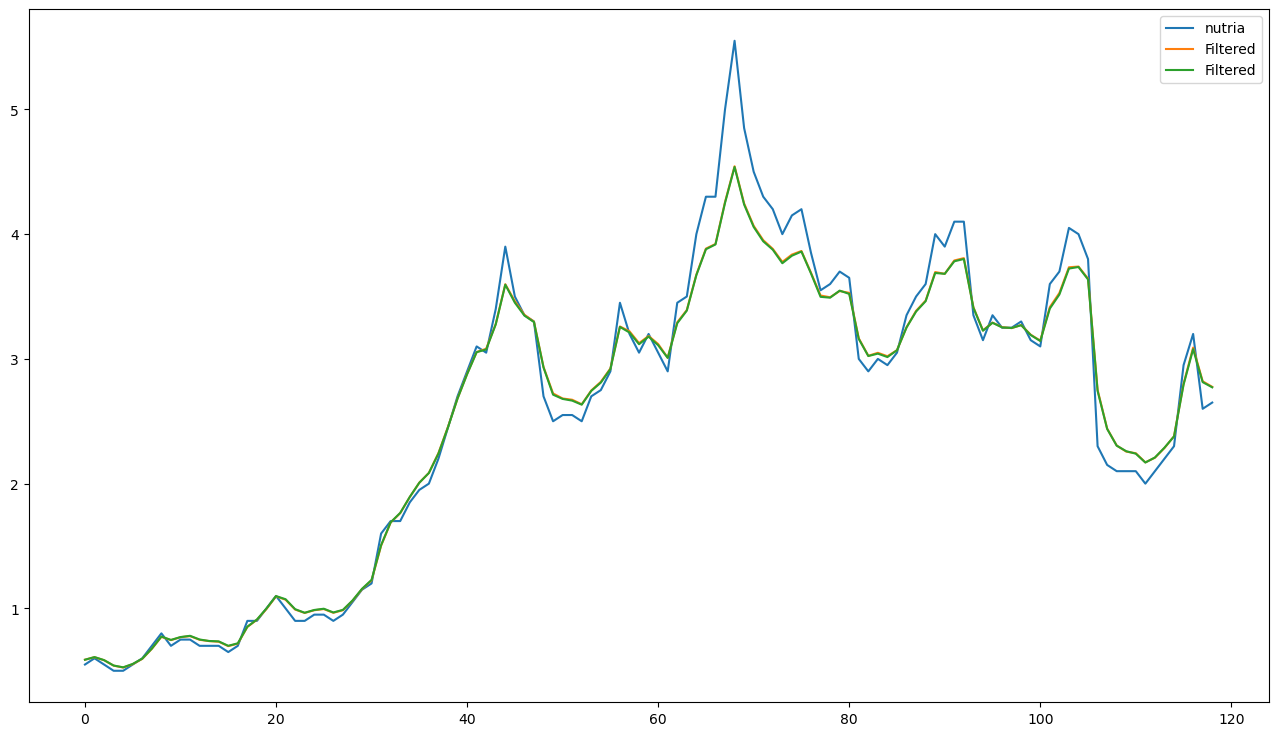

In [4]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16, 9)

fig, ax = plt.subplots()

data.plot(ax=ax)

for _, state in results:
    means = state.normalized_weights() @ state.filter_state.filter_means
    ax.plot(means[1:].exp().cpu().numpy(), label="Filtered")

ax.legend()

Next, let's visualize the posterior distributions of the parameters

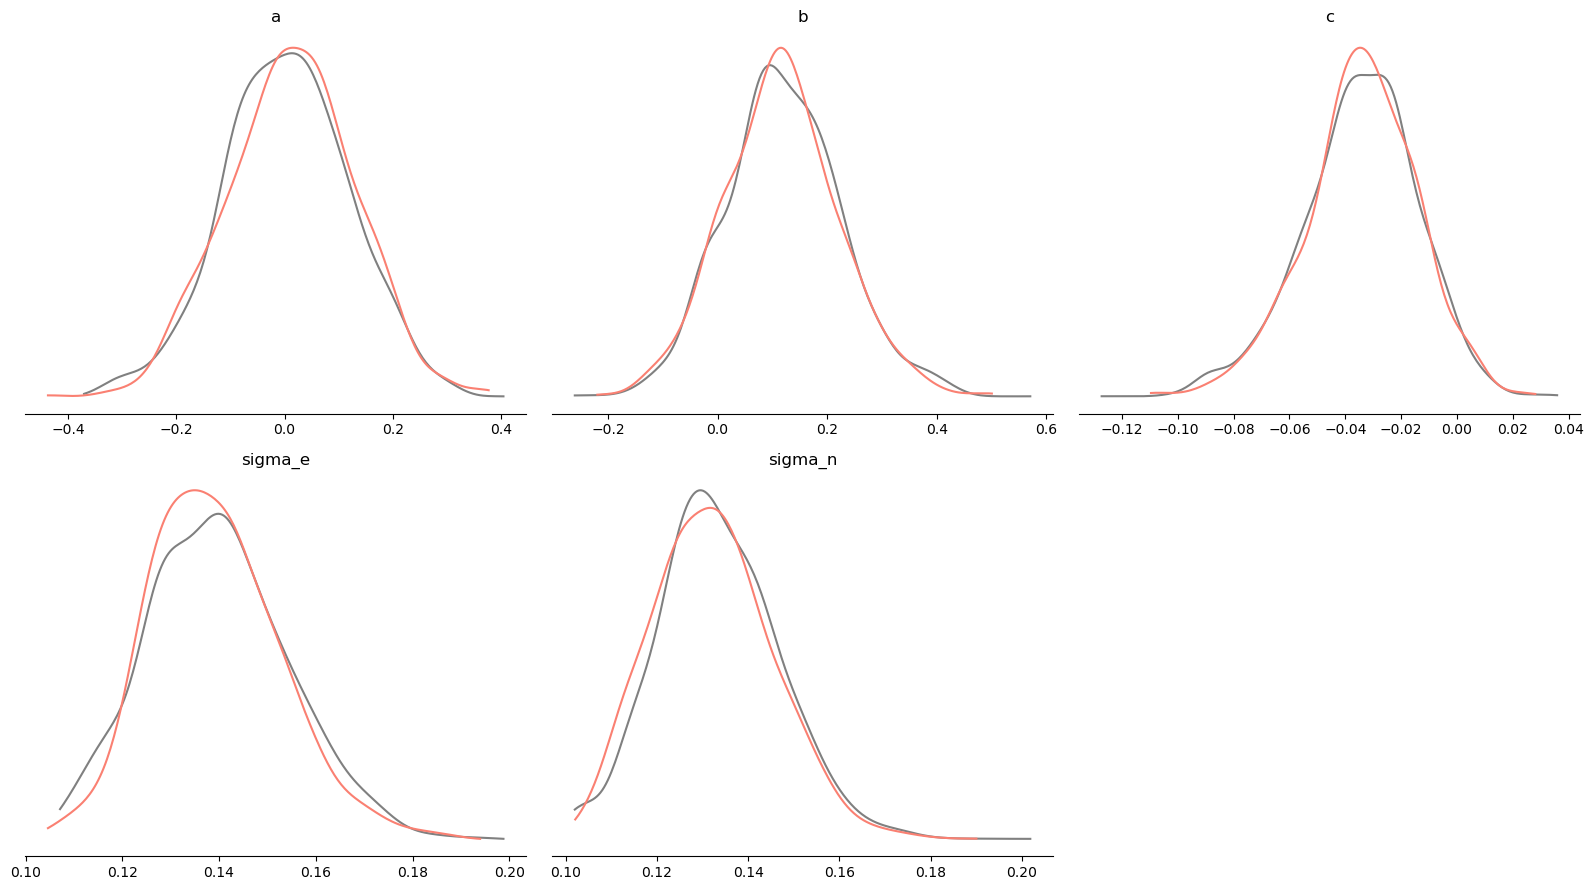

In [5]:
from pyfilter.inference import plot

colors = ["gray", "salmon"]
ax = None

for j, (context, state) in enumerate(results):
    ax = plot.mimic_arviz_posterior(context, state, ax=ax, color=colors[j])

plt.tight_layout()

Comparing the above plots with the ones obtained in [stoch-proc](https://github.com/tingiskhan/stoch-proc/blob/master/examples/nutria.ipynb), we clearly see that we have roughly the same posteriors obtained in a fraction of the time.